In [42]:
import pandas as pd
import numpy as np
import sklearn
import json
import matplotlib.pyplot as plot
from wordcloud import WordCloud
%matplotlib inline

## Read in the user metadata file

In [187]:
# user_metadata_file = 'test.json'
# with open(user_metadata_file) as f:
#     users = json.load(f)
#     user_info= pd.DataFrame(users)

# print(len(user_info))

user_metadata_file = 'user_metadata_latest.jsonl'
user_metadata_list = []
with open(user_metadata_file) as fp:
    for line in fp.readlines():
        user_metadata_list.append(json.loads(line))

user_info = pd.DataFrame(user_metadata_list)

Add columns for follows_sg, follows_professional_sg, and follows_thinspo

In [188]:
user_info['follows_sg'] = None
user_info['follows_professional_sg'] = None
user_info['follows_thinspo'] = None
user_info['is_anorexia_recovery'] = None

In [189]:
user_info.head()

,created_at,description,favourites_count,followers_count,friends_count,id,lang,listed_count,location,name,profile_location,screen_name,statuses_count,time_zone,utc_offset,verified,follows_sg,follows_professional_sg,follows_thinspo,is_anorexia_recovery
0,2013-01-04 14:14:01,recovering from anorexia. inpatient X1 .life i...,63,1842,536,1060558130,en,18,Wonderland,Recovery Vs Relspse,None,BrokenPurge,18326,None,None,False,None,None,None,None
1,2018-07-13 18:37:04,Tweeting all things MH & positive thoughts whi...,41,50,213,1017840348083650560,en,0,,flyingfree,None,flyingf28327022,159,None,None,False,None,None,None,None
2,2017-07-17 17:41:33,Jumping on the bandwagon of 'tweet what you ea...,31,32,185,887004356075286528,en,1,"South West, England",Emily May,None,queenofoats,22,None,None,False,None,None,None,None
3,2016-06-06 11:15:49,New TV series seeks 16-19yr olds suffering fro...,9,77,256,739777811964153856,en-gb,0,"London, England",NewEDProg,None,NewEDProg,221,None,None,False,None,None,None,None
4,2010-02-01 18:36:29,A recovering anorexic simultaneously trying to...,0,4397,5661,110487555,en,108,London,msjoanna cake,None,msjoannacake,3245,None,None,False,None,None,None,None


## Gather information about the number of support groups

In [190]:
support_groups = pd.read_csv('supportgroup.csv', header=1)
print(len(support_groups))
support_groups.head()

35


,screen_name,is_thinspo,is_anorexia_recovery,professional_sg,sg,follows_thinspo,Notes
0,cheers_forana,TRUE,False,NaN,NaN,TRUE,NaN
1,lifeoverAna,FALSE,True,"Silencing_ED,EatingRecovery,loveyourbody,EDCar...","angelaegambrel,ichosetolive,HopefulRecovery,An...",FALSE,NaN
2,BrokenPurge,FALSE,True,"AnorexiaDaily,Spreading_L0ve,SelfHarmWIILEnd,A...","scalesR4fish,StandStr0ng,DyingDaisy_,AwareOfSe...",TRUE,NaN
3,xbertyx,FALSE,True,"ProjectBuddy,AgainstSuicide",EndThePain_,TRUE,Fitness enthu
4,flyingf28327022,NaN,NaN,NaN,NaN,NaN,Private user


In [191]:
professional_sg_set = set()
sg_set = set()

THRESHOLD = 2

for i in range(len(support_groups)):
    screen_name = support_groups.loc[i, 'screen_name']
    
    # can be empty
    idx = user_info.index[user_info['screen_name'] == screen_name]
    
    # get professional support groups
    professional_sg = support_groups.loc[i, 'professional_sg']
    if not pd.isnull(professional_sg) and professional_sg is not '-':
        sgs = list(map(lambda x: x.lower(), professional_sg.split(',')))
        # Classify user as following professional SG if they follow >= THRESHOLD professional SG's
        if not idx.empty:
            user_info.at[idx, 'follows_professional_sg'] = len(sgs) >= THRESHOLD
        professional_sg_set.update(sgs)
    
    # get non-professional support groups
    sg = support_groups.loc[i, 'sg']
    if not pd.isnull(sg) and sg is not '-':
        sgs = list(map(lambda x: x.lower(), sg.split(',')))
        # Classify user as following SG if they follow >= THRESHOLD SG's
        if not idx.empty:
            user_info.at[idx, 'follows_sg'] = len(sgs) >= THRESHOLD
        sg_set.update(sgs)
        
    is_anorexia_recovery = support_groups.loc[i, 'is_anorexia_recovery']
    if not pd.isnull(sg) and sg is not '-':
        if not idx.empty:
            user_info.at[idx, 'is_anorexia_recovery'] = is_anorexia_recovery == True
    
    follows_thinspo = support_groups.loc[i, 'follows_thinspo']
    if not pd.isnull(sg) and sg is not '-':
        if not idx.empty:
            user_info.at[idx, 'follows_thinspo'] = follows_thinspo == 'TRUE'
        sg_set.update(sgs)

print("# professional support groups: {}".format(len(professional_sg_set)))
print("# non-professional support_groups: {}".format(len(sg_set)))

# professional support groups: 102
# non-professional support_groups: 106


Classify the users in the users_info data frame as following professional support groups, non-professional support groups, or neither

In [192]:
# Verify that the new columns are populated
user_info.head()

,created_at,description,favourites_count,followers_count,friends_count,id,lang,listed_count,location,name,profile_location,screen_name,statuses_count,time_zone,utc_offset,verified,follows_sg,follows_professional_sg,follows_thinspo,is_anorexia_recovery
0,2013-01-04 14:14:01,recovering from anorexia. inpatient X1 .life i...,63,1842,536,1060558130,en,18,Wonderland,Recovery Vs Relspse,None,BrokenPurge,18326,None,None,False,True,True,True,True
1,2018-07-13 18:37:04,Tweeting all things MH & positive thoughts whi...,41,50,213,1017840348083650560,en,0,,flyingfree,None,flyingf28327022,159,None,None,False,None,None,None,None
2,2017-07-17 17:41:33,Jumping on the bandwagon of 'tweet what you ea...,31,32,185,887004356075286528,en,1,"South West, England",Emily May,None,queenofoats,22,None,None,False,True,True,False,True
3,2016-06-06 11:15:49,New TV series seeks 16-19yr olds suffering fro...,9,77,256,739777811964153856,en-gb,0,"London, England",NewEDProg,None,NewEDProg,221,None,None,False,None,None,None,None
4,2010-02-01 18:36:29,A recovering anorexic simultaneously trying to...,0,4397,5661,110487555,en,108,London,msjoanna cake,None,msjoannacake,3245,None,None,False,None,True,None,None


Drop the rows that have protected twitter accounts

In [193]:
user_info = user_info[user_info.follows_sg.notnull()]

In [57]:
from TweetPreprocessor import TweetPreprocessor

def get_support_groups_from_list(followers):
    support_groups = []
    for follower in followers:
        description, verified = TweetPreprocessor.pipeline(follower['description'].lower()), follower['verified']
        print(description)
    return support_groups

In [58]:
cols = ['description', 'verified', 'friend_id', 'associated_screen_name']
rows = []

num_users = user_info.shape[0]

for i in range(num_users):
    friends = user_info.iloc[i].followers
    screen_name = user_info.iloc[i].screen_name
    if isinstance(friends, list):
        print("{} has {} friends".format(screen_name, len(friends)))
        for friend in friends:
            # only want english speaking
            if 'en' in friend['lang']:
                description, verified = TweetPreprocessor.pipeline(friend['description'].lower()), friend['verified']
                rows.append([description, verified, friend['id'], screen_name])
            
followers_df = pd.DataFrame(rows)
followers_df.columns = cols
print("\nFound {} friends".format(followers_df.shape[0]))
followers_df.head()

AttributeError: 'Series' object has no attribute 'followers'

In [59]:
# Try some unsupervised learning to classify the users based on description
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.feature_extraction.text import TfidfVectorizer
n_clusters = 3

vectorizer = TfidfVectorizer(max_df=0.5, max_features=10000,
                                 min_df=2, stop_words='english')
X = vectorizer.fit_transform(followers_df.description)

km = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=100, n_init=1)
labels = km.fit_predict(X)
print("KMeans with {} clusters fit".format(n_clusters))
print(labels)
assert(len(labels) == followers_df.shape[0])
for i in range(followers_df.shape[0]):
    followers_df.loc[i, 'class'] = labels[i]
followers_df[['description', 'class']]

for i in range(n_clusters):
    class_df = followers_df[followers_df['class'] == i]
    print("=" * 20, "Class number {}: ({} users)".format(i, class_df.shape[0]), "=" * 20)
    print(class_df.head())

NameError: name 'followers_df' is not defined

In [60]:
dump = user_info[['description','statuses_count', 'screen_name', 'followers']]

KeyError: "['followers'] not in index"

In [61]:
dump

NameError: name 'dump' is not defined

### Reading in Tweets file

In [194]:
tweet_file = 'user_tweets_latest.jsonl'
tweet_train = []
with open(tweet_file) as fp:
    for line in fp.readlines():
        tweet_train.append(json.loads(line))

In [195]:
tweets = pd.DataFrame(tweet_train)

In [196]:
tweets['tweeter_screen_name'].unique()

array(['HanBaNannz', 'elamame_bean', 'msjoannacake', 'cheers_forana',
       'AdriennesAngels', 'xbertyx'], dtype=object)

Drop tweets with urls because I noticed that a lot of people are putting spam tweets such as:
"My daily stats: 19 new followers, 5 new unfollowers via http://t.co/LYJ6IqurZF

In [197]:
def drop_tweets_with_urls(df):
    num_dropped = 0
    print(len(df))
    for i in range(df.shape[0]):
        urls = df.at[i, 'entities']['urls']
        if len(urls) > 0:
            df.drop(i, inplace=True)
            num_dropped += 1
    print("Dropped {}".format(num_dropped))
    df.reset_index(inplace=True)
    print(len(df))
    return df

In [198]:
tweets = drop_tweets_with_urls(tweets)

9076
Dropped 2318
6758


In [199]:
# TODO: Classify the users as having a support group or not

### Sentiment Analysis

In [200]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from imp import reload
import TweetPreprocessor
reload(TweetPreprocessor)
from TweetPreprocessor import TweetPreprocessor 

analyser = SentimentIntensityAnalyzer()

def analyse_sentiment(tweeter, preprocess=False):
    for i in range(0, tweeter.shape[0]):
        text = tweeter.iloc[i].text
        np_score = analyser.polarity_scores(text)
        
        preprocessed_text = TweetPreprocessor.pipeline(text)
        score = analyser.polarity_scores(preprocessed_text)
        
        tweeter.loc[i, 'processed_text'] = preprocessed_text
        
        tweeter.loc[i, 'compound'] = score['compound']
        tweeter.loc[i, 'pos'] = score['pos']
        tweeter.loc[i, 'neg'] = score['neg']
        tweeter.loc[i, 'neu'] = score['neu']
        
        tweeter.loc[i, 'compound_np'] = np_score['compound']
        tweeter.loc[i, 'pos_np'] = np_score['pos']
        tweeter.loc[i, 'neg_np'] = np_score['neg']
        tweeter.loc[i, 'neu_np'] = np_score['neu']      
    return tweeter


[nltk_data] Downloading package wordnet to /Users/jtsui/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [201]:
analysed_users = analyse_sentiment(pd.DataFrame(tweets))

In [202]:
analysed_users[['processed_text', 'text']].head()

,processed_text,text
0,whenever i talk negatively about my recovering...,Whenever I talk negatively about my recovering...
1,lillard rock bottom will teach you lessons th...,RT @Dame_Lillard: Rock bottom will teach you l...
2,white folks,RT @PatMcAfeeShow: White folks https://t.co/Bu...
3,a story in pictures littlesister gogreen,RT @BarstoolMSU: A story in 4 pictures\n\n#Lit...
4,two cancer survivors share a moment connerstr...,RT @BleacherReport: Two cancer survivors share...


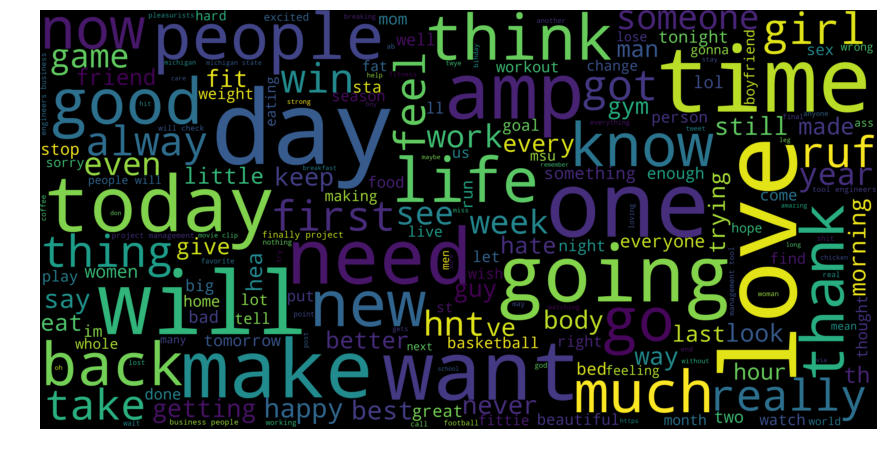

In [203]:
wordcloud_string = ''
for i in range(analysed_users.shape[0]):
    wordcloud_string += analysed_users.iloc[i].processed_text

wordcloud = WordCloud(width=4000, height=2000,max_font_size=500).generate(wordcloud_string)
plot.figure(figsize=(15,12))
plot.imshow(wordcloud, interpolation="bilinear")
plot.axis("off")
plot.show()

wordcloud.to_file("wordcloud.png")

### Topic Modeling

In [204]:
from sklearn.feature_extraction.text import TfidfVectorizer

vec = TfidfVectorizer(stop_words='english')
tfidf_result = vec.fit_transform(analysed_users.processed_text)
feature_names = vec.get_feature_names()

tfidf_result.shape

(6758, 8314)

In [205]:
def top_n(tfidf_result, feature_names, top=100):
        if feature_names is None or tfidf_result is None:
            return

        scores = zip(feature_names,
                     np.asarray(tfidf_result.sum(axis=0)).ravel())

        sorted_scores = sorted(scores, key=lambda x: x[1], reverse=True)

        labels, scores = [], []

        # Get the scores and labels of the top 100 tweets
        for item in sorted_scores[:top]:
            print("{0:50} Score: {1}".format(item[0], item[1]))
            # sns.distplot(item[1], label=item[0])
            labels.append(item[0])
            scores.append(item[1])

        index = np.arange(len(scores))
        plot.bar(index, scores, figure=plot.figure(figsize=(25, 10)))
        plot.xlabel('Word', fontsize=24)
        plot.ylabel('TFIDF Score', fontsize=24)
        plot.xticks(index, labels, fontsize=12, rotation=90)
        plot.title('Top {} features'.format(top))
        plot.savefig('Top_{}'.format(top))

news                                               Score: 182.90401812088356
just                                               Score: 83.87425957664236
love                                               Score: 82.73400603404316
like                                               Score: 68.46901417909679
day                                                Score: 59.1910293164794
pleasurists                                        Score: 51.61658710138486
people                                             Score: 49.239140017814414
time                                               Score: 46.98163343111682
good                                               Score: 45.39439366129917
lol                                                Score: 43.586591956193715
happy                                              Score: 43.1823284507827
want                                               Score: 43.09510949037846
best                                               Score: 41.69878468891629
today      

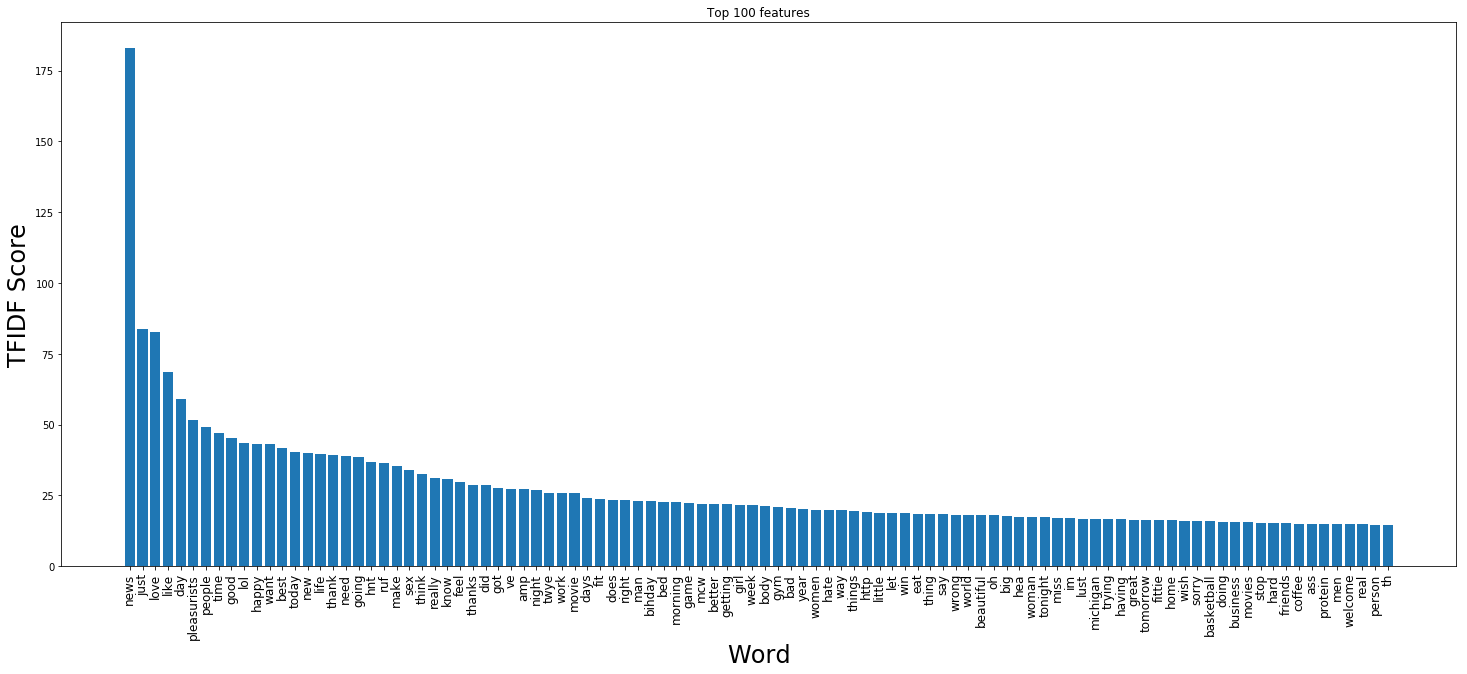

In [206]:
top_n(tfidf_result, feature_names, top=100)

In [158]:
# Topic Modeling
from sklearn.decomposition import NMF, LatentDirichletAllocation, TruncatedSVD

num_topics = 10

lda_model = LatentDirichletAllocation(n_topics=num_topics, max_iter=10, learning_method='online')
lda_Z = lda_model.fit_transform(tfidf_result)
print('LDA shape: ')
print(lda_Z.shape)  # (NO_DOCUMENTS, NO_TOPICS)

# Build a Non-Negative Matrix Factorization Model
nmf_model = NMF(n_components=num_topics)
nmf_Z = nmf_model.fit_transform(tfidf_result)
print('NMF shape: ')
print(nmf_Z.shape)  # (NO_DOCUMENTS, NO_TOPICS)

# Build a Latent Semantic Indexing Model
lsi_model = TruncatedSVD(n_components=num_topics)
lsi_Z = lsi_model.fit_transform(tfidf_result)
print('LSI shape: ')
print(lsi_Z.shape)  # (NO_DOCUMENTS, NO_TOPICS)


/Users/jtsui/.pyenv/versions/3.6.5/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


LDA shape: 
(6758, 10)
NMF shape: 
(6758, 10)
LSI shape: 
(6758, 10)


In [207]:
def print_topics(model, top_n=10):
        for idx, topic in enumerate(model.components_):
            print("Topic %d:" % (idx))
            print([(vec.get_feature_names()[i], topic[i]) for i in topic.argsort()[:-top_n - 1:-1]])

In [208]:
# Let's see how the first document in the corpus looks like in different topic spaces
print("LDA Model:")
print("=" * 20)
print_topics(lda_model)
print("=" * 20, '\n')

print("NMF Model:")
print("=" * 20)
print_topics(nmf_model)
print("=" * 20, '\n')

print("LSI Model:")
print("=" * 20)
print_topics(lsi_model)
print("=" * 20, '\n')

LDA Model:
Topic 0:
[('days', 19.52316214612818), ('say', 18.940364440749956), ('http', 17.614230352857536), ('day', 17.488705911230028), ('new', 16.98343371139785), ('body', 16.515668414411515), ('way', 15.14402366748256), ('news', 14.916755931526327), ('year', 14.102895677966488), ('fat', 13.789784040715759)]
Topic 1:
[('thanks', 30.316181011745897), ('hate', 20.218556151230384), ('sorry', 15.581231858987154), ('muscle', 13.210398654011984), ('fitspo', 12.98041349964343), ('cool', 12.83568066135429), ('aw', 12.044847491028618), ('fittt', 8.572503077191358), ('true', 7.928505957260341), ('selfshot', 7.86070299186186)]
Topic 2:
[('good', 27.511087149144803), ('want', 25.269359371503985), ('just', 22.182981827357544), ('oh', 19.69938300806056), ('know', 18.91050133663024), ('did', 17.3593730282483), ('happened', 16.712425000528075), ('think', 16.454804843054966), ('dm', 15.962970276898957), ('eating', 15.262590109877582)]
Topic 3:
[('thank', 33.30579327774169), ('fittie', 20.29945067323

#### Add "follows_professional_sg" and "follows_sg" column to analysed_users

In [209]:
analysed_users["follows_sg"] = False
t = list(user_info[user_info["follows_sg"] == True]["screen_name"])
analysed_users.loc[analysed_users["tweeter_screen_name"].isin(t), "follows_sg"] = True

analysed_users["follows_professional_sg"] = False
t = list(user_info[user_info["follows_professional_sg"] == True]["screen_name"])
analysed_users.loc[analysed_users["tweeter_screen_name"].isin(t), "follows_professional_sg"] = True

analysed_users.head()

,index,created_at,entities,id,in_reply_to_status_id,in_reply_to_user_id,text,truncated,tweeter_id,tweeter_screen_name,...,compound,pos,neg,neu,compound_np,pos_np,neg_np,neu_np,follows_sg,follows_professional_sg
0,0,2018-10-16 22:35:35,"{'hashtags': [], 'symbols': [], 'user_mentions...",1052327221975748608,NaN,NaN,Whenever I talk negatively about my recovering...,False,41652445,HanBaNannz,...,0.7778,0.194,0.087,0.720,0.7778,0.194,0.087,0.720,False,False
1,2,2018-10-15 23:10:30,"{'hashtags': [], 'symbols': [], 'user_mentions...",1051973619193208832,NaN,NaN,RT @Dame_Lillard: Rock bottom will teach you l...,False,41652445,HanBaNannz,...,0.5106,0.231,0.000,0.769,0.5106,0.216,0.000,0.784,False,False
2,3,2018-10-15 19:20:00,"{'hashtags': [], 'symbols': [], 'user_mentions...",1051915611675287555,NaN,NaN,RT @PatMcAfeeShow: White folks https://t.co/Bu...,False,41652445,HanBaNannz,...,0.0000,0.000,0.000,1.000,0.0000,0.000,0.000,1.000,False,False
3,4,2018-10-14 19:36:01,"{'hashtags': [{'text': 'LittleSister', 'indice...",1051557254464450562,NaN,NaN,RT @BarstoolMSU: A story in 4 pictures\n\n#Lit...,False,41652445,HanBaNannz,...,0.0000,0.000,0.000,1.000,0.0000,0.000,0.000,1.000,False,False
4,5,2018-10-14 16:43:27,"{'hashtags': [{'text': 'ConnerStrong', 'indice...",1051513828079480834,NaN,NaN,RT @BleacherReport: Two cancer survivors share...,False,41652445,HanBaNannz,...,-0.4939,0.162,0.324,0.515,-0.4939,0.125,0.250,0.625,False,False


In [210]:
yays = analysed_users[(analysed_users['follows_sg'] == True) | (analysed_users['follows_professional_sg'] == True)]  
yays.reset_index(inplace=True)
yays_i = np.random.choice(yays.shape[0],2000)
df1 = yays.loc[yays_i]

nays = analysed_users[(analysed_users.follows_sg == False) & (analysed_users.follows_professional_sg == False)]
nays.reset_index(inplace=True)
nays_i = np.random.choice(nays.shape[0],2000)
df2 = nays.loc[nays_i]


In [211]:
pd.concat([df1,df2]).head()

,level_0,index,created_at,entities,id,in_reply_to_status_id,in_reply_to_user_id,text,truncated,tweeter_id,...,compound,pos,neg,neu,compound_np,pos_np,neg_np,neu_np,follows_sg,follows_professional_sg
1274,5911,8121,2013-04-29 18:21:16,"{'hashtags': [], 'symbols': [], 'user_mentions...",328937041024913409,NaN,NaN,RT @Buffyshots: @mo_lllly: Being a selfie douc...,False,29069186,...,-0.3612,0.000,0.217,0.783,-0.4738,0.000,0.192,0.808,False,True
917,5554,7746,2013-05-07 20:45:55,"{'hashtags': [{'text': 'twye', 'indices': [54,...",331872545513021440,NaN,NaN,"Soup, bacon, swede, egg, flax and goji berry s...",False,29069186,...,0.0000,0.000,0.000,1.000,0.0000,0.000,0.000,1.000,False,True
1689,6326,8609,2013-04-22 20:52:15,"{'hashtags': [], 'symbols': [], 'user_mentions...",326438321200955392,3.264328e+17,71486142.0,@crazyJackH94 nice. btw i saw u up west brom sat.,False,29069186,...,0.4215,0.318,0.000,0.682,0.4215,0.286,0.000,0.714,False,True
75,4712,6479,2014-09-09 11:29:44,"{'hashtags': [], 'symbols': [], 'user_mentions...",509302633027624960,NaN,NaN,"RT @TheFitBrunettex: You're not ""big boned"" th...",False,29069186,...,0.0000,0.000,0.000,1.000,0.0000,0.000,0.000,1.000,False,True
646,5283,7303,2013-10-23 07:29:59,"{'hashtags': [], 'symbols': [], 'user_mentions...",392915794008752128,NaN,NaN,RT @wiscofitgirl: Night time fitties,False,29069186,...,0.0000,0.000,0.000,1.000,0.0000,0.000,0.000,1.000,False,True


In [212]:
nays.head()

,level_0,index,created_at,entities,id,in_reply_to_status_id,in_reply_to_user_id,text,truncated,tweeter_id,...,compound,pos,neg,neu,compound_np,pos_np,neg_np,neu_np,follows_sg,follows_professional_sg
0,0,0,2018-10-16 22:35:35,"{'hashtags': [], 'symbols': [], 'user_mentions...",1052327221975748608,NaN,NaN,Whenever I talk negatively about my recovering...,False,41652445,...,0.7778,0.194,0.087,0.720,0.7778,0.194,0.087,0.720,False,False
1,1,2,2018-10-15 23:10:30,"{'hashtags': [], 'symbols': [], 'user_mentions...",1051973619193208832,NaN,NaN,RT @Dame_Lillard: Rock bottom will teach you l...,False,41652445,...,0.5106,0.231,0.000,0.769,0.5106,0.216,0.000,0.784,False,False
2,2,3,2018-10-15 19:20:00,"{'hashtags': [], 'symbols': [], 'user_mentions...",1051915611675287555,NaN,NaN,RT @PatMcAfeeShow: White folks https://t.co/Bu...,False,41652445,...,0.0000,0.000,0.000,1.000,0.0000,0.000,0.000,1.000,False,False
3,3,4,2018-10-14 19:36:01,"{'hashtags': [{'text': 'LittleSister', 'indice...",1051557254464450562,NaN,NaN,RT @BarstoolMSU: A story in 4 pictures\n\n#Lit...,False,41652445,...,0.0000,0.000,0.000,1.000,0.0000,0.000,0.000,1.000,False,False
4,4,5,2018-10-14 16:43:27,"{'hashtags': [{'text': 'ConnerStrong', 'indice...",1051513828079480834,NaN,NaN,RT @BleacherReport: Two cancer survivors share...,False,41652445,...,-0.4939,0.162,0.324,0.515,-0.4939,0.125,0.250,0.625,False,False


In [213]:
analysed_users.shape

(6758, 21)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x11fdf8e48>,
      dtype=object)

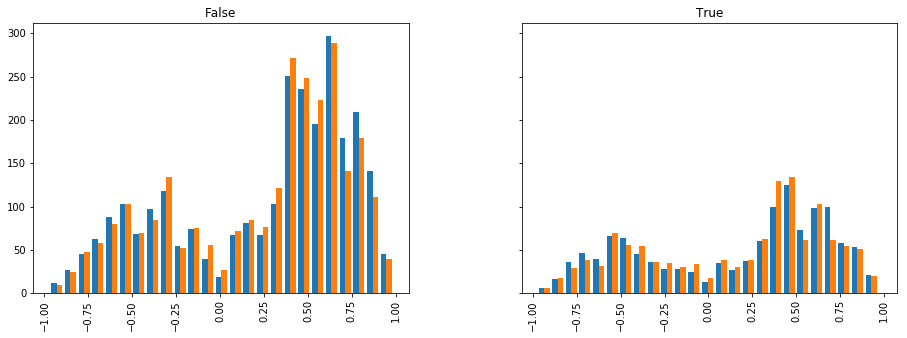

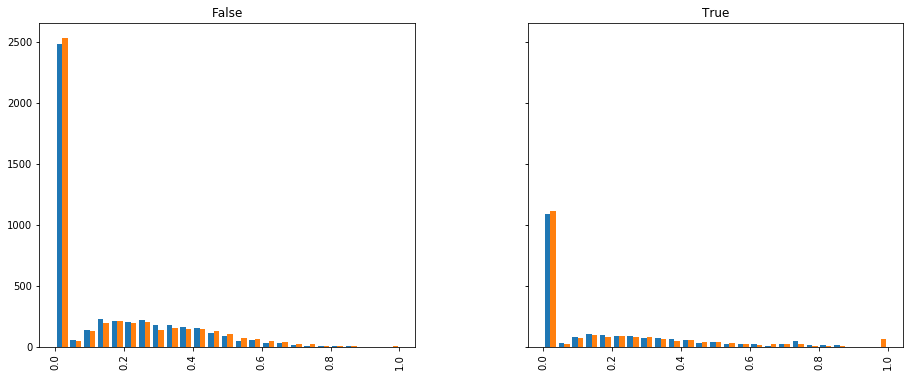

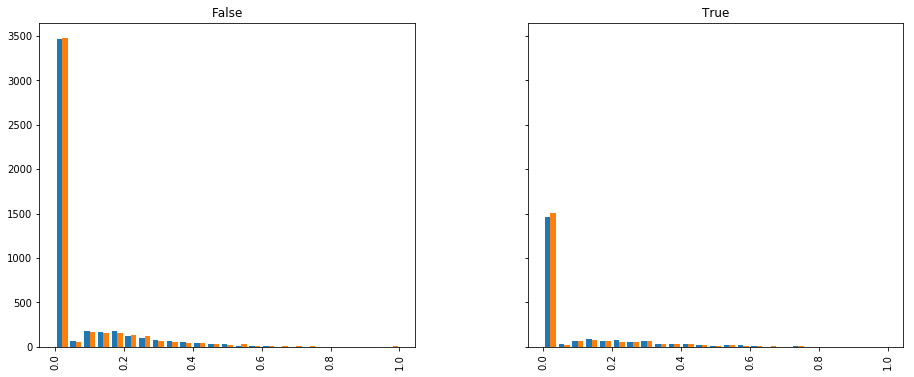

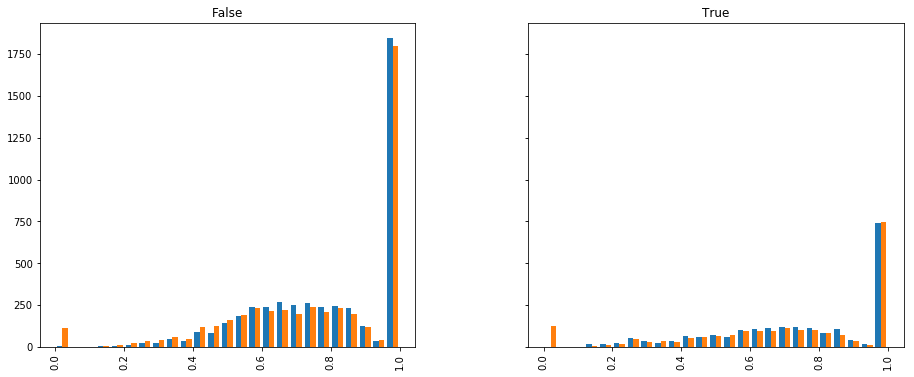

In [214]:
analysed_users['is_support'] = (analysed_users['follows_sg'] == True) | (analysed_users['follows_professional_sg'] == True)
analysed_users.loc[(analysed_users['compound_np'] != 0) & (analysed_users['compound'] != 0)][['compound_np','compound']].hist(bins=25, by=analysed_users['is_support'],figsize=(15,5), sharex=True, sharey=True)
analysed_users[['pos_np','pos']].hist(bins=25, by=analysed_users['is_support'], figsize=(15,6), sharex=True, sharey=True)
analysed_users[['neg_np','neg']].hist(bins=25, by=analysed_users['is_support'], figsize=(15,6), sharex=True, sharey=True)
analysed_users[['neu_np','neu']].hist(bins=25, by=analysed_users['is_support'], figsize=(15,6), sharex=True, sharey=True)


In [215]:
np.unique(analysed_users.is_support, return_counts=True)

(array([False,  True]), array([4637, 2121]))

In [216]:
cols = ['compound', 'pos', 'neg', 'neu']
cols_np = ['compound_np', 'pos_np', 'neg_np', 'neu_np']

In [217]:
analysed_users.shape

(6758, 22)

In [218]:
analysed_users[analysed_users['is_support'] == True][cols].describe()

,compound,pos,neg,neu
count,2121.000000,2121.000000,2121.000000,2121.000000
mean,0.101036,0.177483,0.083470,0.711700
std,0.402108,0.252404,0.160247,0.292289
min,-0.968600,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.545000
50%,0.000000,0.000000,0.000000,0.756000
75%,0.421500,0.294000,0.118000,1.000000
max,0.964800,1.000000,1.000000,1.000000


In [219]:
analysed_users[analysed_users['is_support'] == False][cols].describe()

,compound,pos,neg,neu
count,4637.000000,4637.000000,4637.000000,4637.000000
mean,0.139894,0.150296,0.064096,0.764903
std,0.392288,0.203251,0.137304,0.248942
min,-0.970000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.597000
50%,0.000000,0.000000,0.000000,0.810000
75%,0.458800,0.273000,0.050000,1.000000
max,0.985400,1.000000,1.000000,1.000000


In [220]:
analysed_users.loc[(analysed_users['is_support'] == True) & (analysed_users['compound_np'] !=0) & (analysed_users['compound'] !=0) ][['compound_np','compound']].describe()

,compound_np,compound
count,1234.000000,1234.000000
mean,0.158708,0.151618
std,0.525285,0.506084
min,-0.974400,-0.968600
25%,-0.381000,-0.340000
50%,0.361200,0.340000
75%,0.589650,0.560925
max,0.964800,0.964800


In [221]:
analysed_users.loc[(analysed_users['is_support'] == False) & (analysed_users['compound_np'] !=0) & (analysed_users['compound'] !=0) ][['compound_np','compound']].describe()

,compound_np,compound
count,2679.000000,2679.000000
mean,0.252793,0.238016
std,0.504128,0.489089
min,-0.955200,-0.970000
25%,-0.202300,-0.177900
50%,0.421500,0.400500
75%,0.636900,0.629400
max,0.985400,0.985400


# Network Analysis